In [1]:
from quests_data import *
import seaborn as sns
import itertools
from ase import Atoms
from ase.io import read, write
from quests.tools.plotting import savefig, COLORS
from scipy import stats

In [2]:
def get_rmse(A, B):
    return np.sqrt(((A - B) ** 2).mean())

## Loading the data of $\delta \mathcal{H}$ values and computing the entropy

In [3]:
def load_overlap(train, test, root_dir="../data/02-GAP20/dH", eps=1):
    if train == test:
        return 100
        
    fname = os.path.join(root_dir, f"{test}-{train}.json")
    with open(fname, "r") as f:
        dH = json.load(f)["delta_entropy"]

    return (np.array(dH) < eps).mean() * 100

In [4]:
MODELS = ["Fullerenes", "Graphite", "Nanotubes", "Graphene", "Defects"]
ROOT = "../data/02-GAP20/model-eval"

norms = {}
errors = []
for train in MODELS:
    for test in MODELS:
        # load predictions
        fname = os.path.join(ROOT, train, f"{test}.xyz")
        dset = read(fname, index=":")

        # load ground-truth
        fname_true = os.path.join(ROOT, "true", f"{test}.xyz")
        true = read(fname_true, index=":")
        
        mace_f, true_f = [], []
        for i, (at1, at2) in enumerate(zip(dset, true)):
            mace_f.append(at1.arrays["MACE_forces"])
            true_f.append(at2.get_forces())
        
        mace_f = np.concatenate(mace_f)
        true_f = np.concatenate(true_f)

        rmse = get_rmse(mace_f, true_f)
        errors.append({
            "train": train,
            "test": test,
            "rmse": rmse,
            "overlap": load_overlap(train, test)
        })

        if train == test:
            norms[test] = np.linalg.norm(true_f, axis=1).mean()

errors = pd.DataFrame(errors)
norms = pd.Series(norms)

In [5]:
errors

,train,test,rmse,overlap
0,Fullerenes,Fullerenes,0.124004,100.000000
1,Fullerenes,Graphite,2.495918,9.001637
2,Fullerenes,Nanotubes,0.341122,76.776152
3,Fullerenes,Graphene,0.119743,91.763614
4,Fullerenes,Defects,3.301446,35.341294
5,Graphite,Fullerenes,3.449267,1.354621
6,Graphite,Graphite,0.027619,100.000000
7,Graphite,Nanotubes,0.751237,15.957347
8,Graphite,Graphene,0.111658,51.738861
9,Graphite,Defects,1.512032,15.779495


## Overlap matrix

In [6]:
table = errors.pivot(index="test", columns="train", values="overlap")
table = table.loc[MODELS][MODELS]

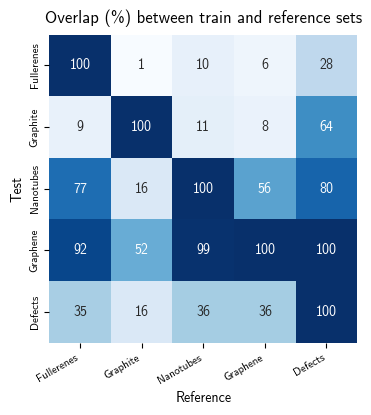

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))

hmap = sns.heatmap(
    table,
    annot=True,
    fmt=".0f",
    square=True,
    cmap="Blues",
    ax=ax,
    cbar=False,
)

ax.set_ylabel("Test")
ax.set_xlabel("Reference")
ax.set_title("Overlap (%) between train and reference sets")

ax.set_xticklabels(table.columns, rotation=30, ha="right")

# savefig(fig, "04-gap20-dH-table.pdf")

plt.show()

## Full overlap matrix

In [8]:
files = os.listdir("../data/02-GAP20/dH")

overlaps = []
for f in files:
    test, train = f.replace(".json", "").split("-")
    overlaps.append({
        "train": train,
        "test": test,
        "overlap": load_overlap(train, test),
    })

overlaps = pd.DataFrame(overlaps).pivot(index="test", columns="train", values="overlap")

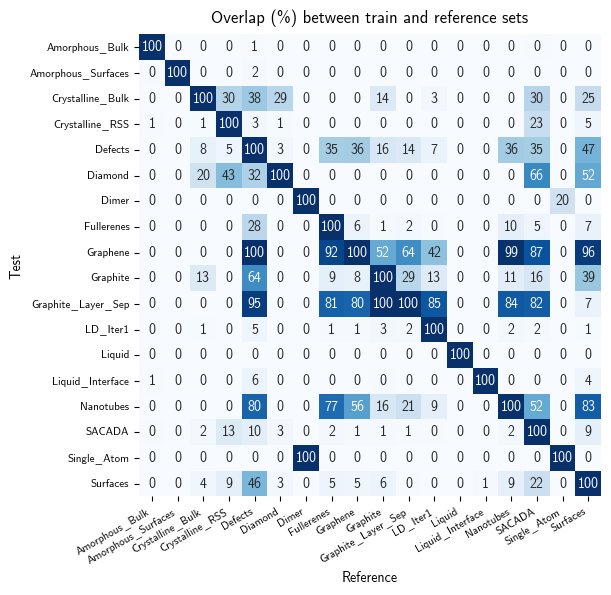

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

hmap = sns.heatmap(
    overlaps,
    annot=True,
    fmt=".0f",
    square=True,
    cmap="Blues",
    ax=ax,
    cbar=False,
)

ax.set_ylabel("Test")
ax.set_xlabel("Reference")
ax.set_title("Overlap (%) between train and reference sets")

ax.set_xticklabels(overlaps.columns, rotation=30, ha="right")

# savefig(fig, "04-gap20-dH-table.pdf")

plt.show()

## Computing the error

In [10]:
baseline = errors.loc[errors["train"] == errors["test"]].set_index("train")["rmse"]

In [11]:
errors["pct"] = (errors["rmse"] - baseline.reindex(errors["test"]).values) / baseline.reindex(errors["test"]).values
errors["normalized"] = errors["rmse"] / norms.reindex(errors["test"]).values

baseline_norm = errors.loc[errors["train"] == errors["test"]].set_index("train")["normalized"]
errors["pct_norm"] = errors["normalized"] - baseline_norm.reindex(errors["test"]).values

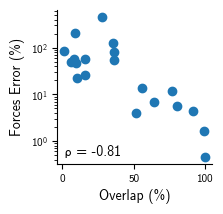

In [12]:
fig, ax = plt.subplots(figsize=(2, 2))

_df = errors.loc[errors["train"] != errors["test"]]

x = _df["overlap"]
y = _df["normalized"] * 100
ax.scatter(x, y)

r = stats.pearsonr(x, np.log(y))
ax.annotate(f"ρ = {r.statistic:.2f}", (0.05, 0.05), xycoords="axes fraction")

ax.set_yscale("log")

ax.set_xlabel("Overlap (%)")
ax.set_ylabel("Forces Error (%)") 

# savefig(fig, "05-uq-corr-2.pdf")
plt.show()